In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import mne, re, os
import torch
import pickle

from utils import *

In [3]:
SNR = 100.0
#PARCELLATION = 'aparc.a2009s'
PARCELLATION = 'HCPMMP1_combined'
DATA_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/'

data_dict = load_mmidb_data_dict(DATA_PATH, PARCELLATION, SNR, chop=True)

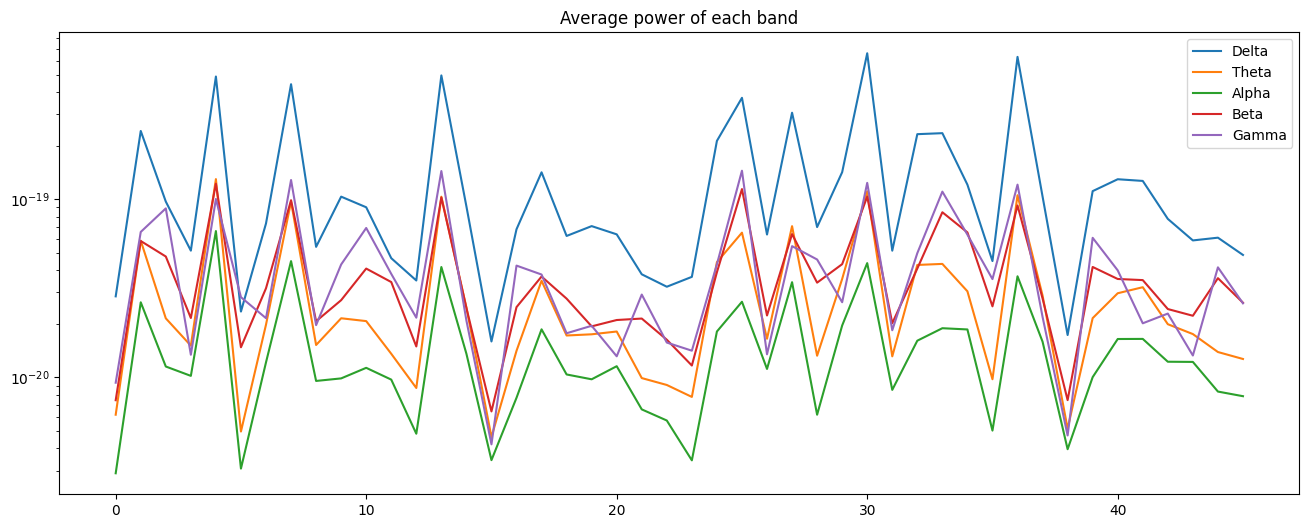

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
for band in bands:
    ax.plot(data_dict[band]['S001']['S001R01']['T0'].mean(axis=0), label=band)


ax.set_yscale('log')

ax.set_title('Average power of each band')
ax.legend()




plt.show()


In [4]:
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

patient = 'S001'
baseline_run = 'R01'

np.array([data_dict[band][patient][patient+baseline_run]['T0'] for band in bands]).shape

(5, 15, 46)

In [3]:
DATA_PATH_RAW = '../../data/eegmmidb (raw)/files/'
DATA_PATH_CONCEPTS = '../../data/baseline concepts MMIDB/'

bands = data_dict.keys()
patients_to_exclude = ['S088', 'S089', 'S090', 'S092', 'S104', 'S106']
patients = [key for key in data_dict['Alpha'].keys() if key not in patients_to_exclude]
#runs = [key[-3:] for key in data_dict['Alpha'][patients[0]].keys()]
runs = ['R01', 'R02']

subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()
labels = get_labels(subjects_dir, parcellation_name=PARCELLATION)
label_names = [label.name for label in np.array(labels).flatten()]

bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

In [4]:
for label_idx in range(len(label_names)):
    for band in bands:
    # make directory if it doesn't exist
        if not os.path.exists(f'{DATA_PATH_CONCEPTS}{band}_{label_names[label_idx]}'):
            os.makedirs(f'{DATA_PATH_CONCEPTS}{band}_{label_names[label_idx]}')

In [5]:
NUMNER_PATIENTS = len(patients)
NUMBER_RUNS = len(runs)
NUMBER_WINDOWS = 15
NUMBER_CHANNELS = 20

WINDOW_LENGTH = 4 # seconds
SAMPLING_FREQ = 256 # Hz
NUMBER_SAMPLES = int(WINDOW_LENGTH*SAMPLING_FREQ)



baseline_run = 'R01' # baseline open eyes

X = np.zeros((NUMNER_PATIENTS, NUMBER_RUNS, NUMBER_WINDOWS, NUMBER_CHANNELS, NUMBER_SAMPLES))
Y = np.ones((NUMNER_PATIENTS, NUMBER_RUNS, NUMBER_WINDOWS)) * -1

for patient in tqdm(patients):
    for run in runs:

        FILE = DATA_PATH_RAW+f'{patient}/{patient}{run}.edf'

        raw = get_raw(FILE)

        raw_chops = get_raw_chops(raw)

        baseline_activity = np.array([data_dict[band][patient][patient+baseline_run]['T0'] for band in bands])

        for chop_idx, raw_chop in enumerate(raw_chops):
            raw_chop = pick_and_rename_MMIDB_channels(raw_chop)  

            activity = np.array([data_dict[band][patient][patient+run]['T0'][chop_idx] for band in bands])

            try:
                activity -= baseline_activity[:, chop_idx]
            except:
                break

            most_active_band_idx = np.argmax(activity.mean(axis=1))
            most_active_band = bands[most_active_band_idx]

            brain_region_idx = activity[most_active_band_idx].argmax()
            brain_region = label_names[brain_region_idx]

            concept = most_active_band + '_' + brain_region       

            try: 
                x = np.zeros((1, NUMBER_CHANNELS, NUMBER_SAMPLES))
                x[:,:19,:] = raw_chop.copy().get_data()[:,:NUMBER_SAMPLES].reshape(1,NUMBER_CHANNELS-1,NUMBER_SAMPLES)
                x[:,19,:] = np.ones((1, NUMBER_SAMPLES)) * -1  
                x = torch.from_numpy(x).float()
                
                picklePath = DATA_PATH_CONCEPTS + concept + '/' + patient + run + '_' + concept + '.pkl'
                with open(picklePath, 'wb') as handle:
                    pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)
            except:
                print('Error with file: ' + FILE,x.shape)

100%|██████████| 104/104 [00:55<00:00,  1.88it/s]
